<a href="https://colab.research.google.com/github/cruz-marco/dinamicas_dex_days/blob/main/Estatistica_avancada_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETAPA 0 - CARREGAMENTO DAS BIBLIOTECAS

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import patsy as pt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge

## EXERCÍCIO 1 - CARREGAMENTO, EDA E PRÉ-PROCESSAMENTO

In [11]:
raw_dataset =  pd.read_csv('/content/drive/MyDrive/Datasets/Startups/50_Startups.csv')
raw_dataset.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.90, 0.99])

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
5%,748.231000,73613.302000,856.768500,45678.689000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
90%,135364.648000,153540.042000,363192.066000,157910.802000
99%,164000.965000,170419.256400,458120.170700,192031.642700


In [12]:
raw_dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


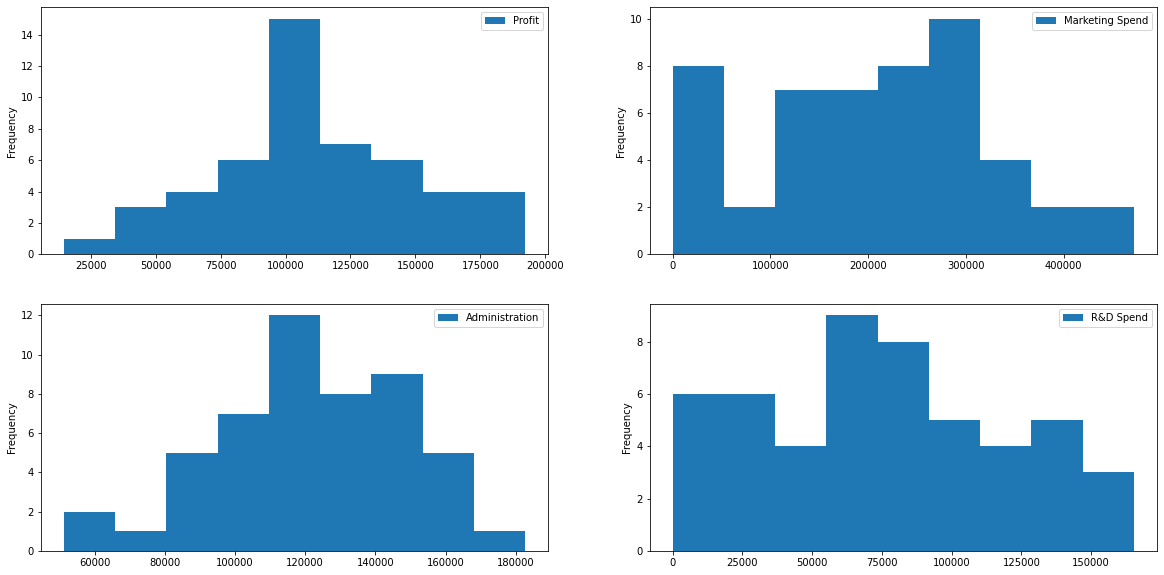

In [40]:
#plotando Histogramas
fr_cols = list(raw_dataset.select_dtypes(include='number').columns)
col_index = len(fr_cols) - 1 #numero de indices possiveis no array acima.

ncols = 2 #numero de colunas
nrows = int(np.ceil(len(fr_cols)/(1.0 * ncols))) #numero de linhas


fig, axes = plt.subplots(nrows,ncols, figsize=(20, 10)) # Criando a figura e os 
                                                #eixos num array para plotagem.

for lines in axes: #itera nas linhas
  for cols in lines: #itera nas colunas dentro das linhas
    if col_index >= 0:  #verifica o indice a ser usado

      linha = np.where(axes == lines)[0][0] #pega o index da linha
      coluna = np.where(lines == cols)[0][0] #pega o index da coluna

      raw_dataset[fr_cols[col_index]].plot.hist(bins=9,
      label=fr_cols[col_index].replace('_', ' ').title(), 
      subplots=True, legend=True, ax=axes[linha , 
      coluna]) #comando de plot para a figura

      col_index -= 1 #diminui um do indice
      
    else:      
      plt.axis('off')
      #break  

plt.show()

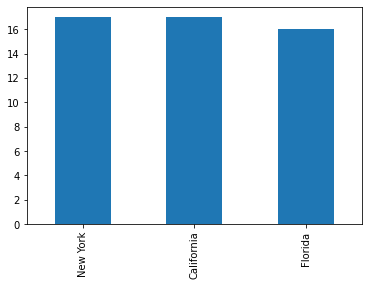

In [68]:
#Plotando gráfico de barras da categoria estado.

raw_dataset.State.value_counts().plot.bar()

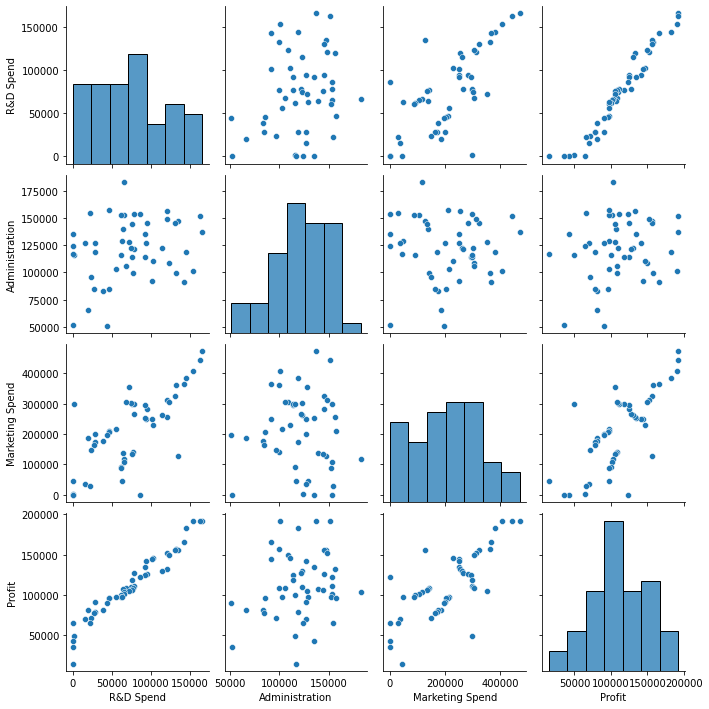

In [70]:
#Gráfico de correlação.
sns.pairplot(raw_dataset)

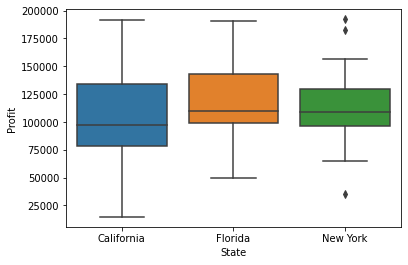

In [102]:
#fazendo o boxplot do lucro por estado

#fig = plt.figure() para usar funções do matplot no seaborn.

sns.boxplot(x=raw_dataset.State, y=raw_dataset.Profit)

In [75]:
#gerando um dataset com as variaveis numericas
dfNum = raw_dataset.select_dtypes(include='number').drop('Profit', axis=1)
dfNum.head()

,R&D Spend,Administration,Marketing Spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42


In [78]:
#Definindo Stats como categoria
raw_dataset.State = raw_dataset.State.astype('category')

#Selecionando apenas as variáveis categóricas.
dfCat = raw_dataset.select_dtypes(include='category')
dfCat.head()

,State
0,New York
1,California
2,Florida
3,New York
4,Florida


In [80]:
#Separando a variável resposta.
y = raw_dataset['Profit']
y.head()

0    192261.83
1    191792.06
2    191050.39
3    182901.99
4    166187.94
Name: Profit, dtype: float64

In [82]:
# Testando a normalidade da resposta
KStat, KPvalue = sp.stats.kstest(y, 'norm')
print(KStat, KPvalue, sep=' - ')

1.0 - 0.0


1.0 - 0.0


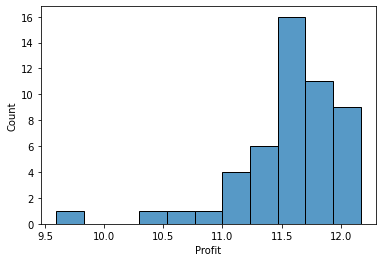

In [83]:
#Aplicando o log na resposta
KStat, KPvalue = sp.stats.kstest(np.log(y), 'norm')
print(KStat, KPvalue, sep=' - ')

#Melhor usar a resposta sem o log.
sns.histplot(np.log(y))

In [98]:
#Definindo a função de escalonamento de variáveis.
def feat_scale(dataframe):
  med = np.mean(dataframe, axis=0) # pegando a média das variáveis
  desv = np.std(dataframe, axis=0, ddof=1) #desvio padrão amostral DDOF=1

  normal = (dataframe - med)/desv
  return normal


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ad3240b10>,
      dtype=object)

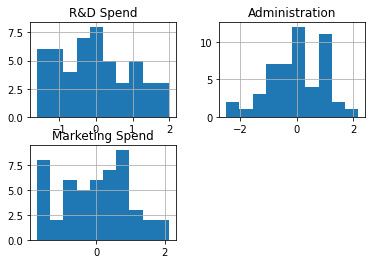

In [88]:
dfNorm = feat_scale(dfNum)

dfNorm.hist()

In [104]:
#Tratamento das variáveis categóricas.

dfDum = pd.get_dummies(dfCat)

dfDum.rename(columns = {'State_New York':'State_New_York'}, inplace=True)

dfDum.head()

,State_California,State_Florida,State_New_York
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,1,0


In [110]:
#Concatenando as variáveis continuas e categóricas.
dfFinal = pd.concat([dfNorm, dfDum], axis=1)

#renomeando as features
dfFinal.rename(columns={'R&D Spend': 'rd',
                        'Marketing Spend': 'mkt',
                        'Administration': 'adm',
                        'State_California': 'ca',
                        'State_Florida': 'fl',
                        'State_New_York': 'ny'},
               inplace=True)

dfFinal.head()

,rd,adm,mkt,ca,fl,ny
0,1.996146,0.555117,2.132295,0,0,1
1,1.936203,1.071924,1.904267,1,0,0
2,1.736731,-0.720938,1.610180,0,1,0
3,1.539157,-0.095396,1.407916,0,0,1
4,1.489812,-1.069066,1.268648,0,1,0


In [109]:
#Adição da resposta
dfFull = pd.concat([y, dfFinal], axis = 1).rename(columns={'Profit':'pft'})
dfFull.head()

,pft,rd,adm,mkt,ca,fl,ny
0,192261.83,1.996146,0.555117,2.132295,0,0,1
1,191792.06,1.936203,1.071924,1.904267,1,0,0
2,191050.39,1.736731,-0.720938,1.610180,0,1,0
3,182901.99,1.539157,-0.095396,1.407916,0,0,1
4,166187.94,1.489812,-1.069066,1.268648,0,1,0


In [129]:
# definindo a runção para escrever a fórmula de dependência:

def ols_formula(df, dep_var, *excluded_cols):
  cols = list(df.columns) #  transformando em lista os campos das colunas
  cols.remove(dep_var) #  removendo a variável de interesse.
  
  if len(excluded_cols) > 0: #caso haja mais variaveis a serem removidas.
    for col in excluded_cols:
      cols.remove(col)
  
  return f'{dep_var} ~ ' + ' + '.join(cols)


'pft ~ rd + adm + mkt + ca + fl + ny'

## EXERCÍCIO 2 - AJUSTE DO MODELO (MÉTODO DOS MÍNIMOS QUADRADOS)


In [130]:
#Matriz do modelo metodo dos minimos quadrados.

y, X = pt.dmatrices(ols_formula(dfFull, 'pft'), data = dfFull, return_type='dataframe')

In [134]:
y.head()

,pft
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


In [135]:
X.head()

,Intercept,rd,adm,mkt,ca,fl,ny
0,1.0,1.996146,0.555117,2.132295,0.0,0.0,1.0
1,1.0,1.936203,1.071924,1.904267,1.0,0.0,0.0
2,1.0,1.736731,-0.720938,1.610180,0.0,1.0,0.0
3,1.0,1.539157,-0.095396,1.407916,0.0,0.0,1.0
4,1.0,1.489812,-1.069066,1.268648,0.0,1.0,0.0


In [137]:
# Ajuste do modelo 

#Especificação do modelo
reg1 = sm.OLS(y,X)

#Executa o método dos mínimos quadrados.
reg1fit = reg1.fit()


In [138]:
#Imprimindo o sumário da regressão.
print(reg1fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    pft   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           1.34e-27
Time:                        22:41:51   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04   1001.609     83.877      0.0

## EXERCÍCIO 3 - AJUSTE DO MODELO (MÉTODO DO GRADIENTE DESCENDENTE)

## EXERCÍCIO 4 - SIGNIFICÂNCIA ESTATÍSTICA

## EXERCÍCIO 5 - QUALIDADE DO AJUSTE

## EXERCÍCIO 6 - ANÁLISE DO RESÍDUO

## EXERCÍCIO 7 - REGRESSÃO REGULARIZADA